In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from Bio import SeqIO

sns.set(font_scale=1.5, style="ticks")
month="02"

# Reading vaccine effectiveness

In [2]:
subtype_time2vaccine_strains = dict()
subtype_time2ve = dict()

for subtype in ("h3n2", "h1n1"):
    ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
    ve = pd.read_csv(ve_path)
    ve["time_bin"] = [int(year.split("-")[0]) - 2018 + 30 for year in ve["Year"]]
    ve["vaccine effectiveness"] = [x if isinstance(x, float) else float(x[:-1]) for x in ve["VE"].to_numpy()]
    ve["subtype"] = [subtype] * len(ve)
    print(ve)

    time2vaccine_strains = dict()
    time2ve = dict()

    for strains, year, eff in zip(ve["Strain"], ve["Year"], ve["vaccine effectiveness"]):
        if isinstance(eff, float) and np.isnan(eff):
            continue
        
        year = int(year.split("-")[0]) # 2018
        time2vaccine_strains[year] = strains.split("|")
        time2ve[year] = eff
    subtype_time2vaccine_strains[subtype] = time2vaccine_strains
    subtype_time2ve[subtype] = time2ve
#     time2vaccine_strains, time2ve

         Year   VE   95% CI                                     Strain  \
0   2011-2012  39%  (23 52)                            A/Perth/16/2009   
1   2012-2013  39%  (29 47)                        A/Victoria/361/2011   
2   2013-2014  NaN      NaN                            A/Texas/50/2012   
3   2014-2015   6%  (-5 17)                            A/Texas/50/2012   
4   2015-2016  NaN      NaN                 A/Switzerland/9715293/2013   
5   2016-2017  33%  (23 41)                      A/Hong Kong/4801/2014   
6   2017-2018  22%  (12 31)                      A/Hong Kong/4801/2014   
7   2018-2019   9%  (-4 20)            A/Singapore/INFIMH-16-0019/2016   
8   2019-2020  NaN      NaN                           A/Kansas/14/2017   
9   2020-2021  NaN      NaN  A/Hong Kong/2671/2019|A/Hong Kong/45/2019   
10  2021-2022  36%  (21 48)                   A/Cambodia/e0826360/2020   
11  2022-2023  45%  (29 58)            A/Darwin/9/2021|A/Darwin/6/2021   

    time_bin  vaccine effectiveness s

In [3]:
subtype_time2ve

{'h3n2': {2011: 39.0,
  2012: 39.0,
  2014: 6.0,
  2016: 33.0,
  2017: 22.0,
  2018: 9.0,
  2021: 36.0,
  2022: 45.0},
 'h1n1': {2011: 65.0,
  2013: 54.0,
  2015: 45.0,
  2017: 62.0,
  2018: 44.0,
  2019: 30.0,
  2022: 56.0}}

In [4]:
models_results = defaultdict(list)

In [5]:

def get_topk_score_2(virus_dominance_path, vaccine_seq2his, candidate_vaccine_path, virus_id2seq, k=1):
    domiance_df = pd.read_csv(virus_dominance_path)
    virus_seq2dom = dict()
    for src_id, predictrion in zip(domiance_df["src_id"], domiance_df["prediction"]):
        virus_seq2dom[virus_id2seq[src_id]] = predictrion
    
    vaccine_score = []
    vaccine_id = []
    
    for record in SeqIO.parse(candidate_vaccine_path, "fasta"):
        vaccine_seq = str(record.seq)
        result = []
        for virus_seq in virus_seq2dom:
            dd = dict(vaccine_seq2his[vaccine_seq])
            if virus_seq in dd:
                hi = dd[virus_seq]
                result.append((virus_seq2dom[virus_seq], hi))
        topk_hi = sorted(result, key=lambda x: x[0])[:k]
        vaccine_score.append(np.median([x[1] for x in topk_hi]))
    vaccine_score = np.asarray(vaccine_score)[~np.isnan(vaccine_score)]
    ave_score = np.median(vaccine_score)
    return -ave_score
    

In [16]:
threshold=0.4

all_models = set()

res = defaultdict(list)

for year in range(2012, 2021):
    
    subtype2ave_scores = defaultdict(dict)
    subtype2ranking = defaultdict(dict)
    
    for subtype in ("h3n2", "h1n1"):
        if year not in subtype_time2ve[subtype]:
            continue
        virus_seq_path="../../data/gisaid/ha_processed/%d-%s_to_%d-%s_9999M/a_%s/human_minBinSize1000_lenQuantile0.2_minCnt5.fasta" % (year-3, month, year, month,subtype)
        virus_id2seq = dict()
        for record in SeqIO.parse(virus_seq_path, "fasta"):
            virus_id2seq[record.id] = str(record.seq)
            
        
        ##### Our vaccine + HI model
        who_score_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
#         if not os.path.exists(who_score_path):
#             continue
        all_score_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
#         if not os.path.exists(all_score_path):
#             continue

        for root, dirs, files in os.walk(who_score_path, topdown=False):
            for name in files:
                if name == "vaccine_score_and_gt.csv":
                    model_name = os.path.join(root, name).split("vaccine_scores")[1].split("vaccine_score_and_gt.csv")[0].strip("/")        
                    if model_name != "prob=lightning_logs_version_0___hi=max_steps_150k":
                        continue
#                     if model_name != "prob=lightning_logs_version_0___hi=lightning_logs_version_0":
#                         continue
                    
                    df_background = pd.read_csv(os.path.join(all_score_path, model_name, name))
#                     print(df_background)
                    df = pd.read_csv(os.path.join(root, name))

                    ave_score = -np.median(df["score"])
                    background_scores = -df_background["score"]
                    ranking = np.sum(background_scores <= ave_score) / len(background_scores)
                    model_name = "Escapability score (prediction)"
                    subtype2ave_scores[subtype][model_name] = ave_score
                    subtype2ranking[subtype][model_name] = ranking
                    all_models.add(model_name)
                    
                    # ground-truth
                    ave_score = -np.median(df[df["coverage_seq"] > threshold]["gt_score_seq"])                    
                    background_scores = -df_background["gt_score_seq"][df_background["coverage_seq"] > threshold]
                    ranking = np.sum(background_scores <= ave_score) / len(background_scores)
                    model_name = "Escapability score"
                    subtype2ave_scores[subtype][model_name] = ave_score
                    subtype2ranking[subtype][model_name] = ranking
                    all_models.add(model_name)
        
        
        ##### Dominance only
        dominance_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=who/dominance_prediction" % (year, month, subtype)
        if not os.path.exists(dominance_path):
            print("Fail to find", dominance_path)
            continue
#         all_dominance_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/dominance_prediction" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
#         if not os.path.exists(all_dominance_path):
#             print("Fail to find",all_dominance_path)
#             continue

        for root, dirs, files in os.walk(dominance_path, topdown=False):
            for name in files:
                if name == "test_results.csv":
                    model_name = os.path.join(root, name).split("dominance_prediction")[1].split("test_results.csv")[0].strip("/")
#                     df_background = pd.read_csv(os.path.join(all_dominance_path, model_name, name))                

                    if model_name == "history_%d" % ((year - 2018) * 2 + 30):
                        model_name = "Dominance (next)"
                    if model_name == "history_%d" % ((year - 2018) * 2 + 28):
                        model_name = "Dominance (last)"
                    elif model_name == "lightning_logs/version_0":
                        model_name = "Dominance (prediction)"

                    df = pd.read_csv(os.path.join(root, name))
                    if model_name == "evescape":
                        ave_score = -np.median(df["EVEscape score_sigmoid"])
                        background_scores = -df["EVEscape score_sigmoid"]
                    else:
#                         print(model_name, df, df["prediction"], df_background)
                        ave_score = np.sum(np.exp(-df["prediction"]))                    
#                         background_scores = np.exp(-df_background["prediction"])
#                     ranking = np.sum(background_scores <= ave_score) / len(background_scores)
                    subtype2ave_scores[subtype][model_name] = ave_score
#                     subtype2ranking[subtype][model_name] = ranking
                    all_models.add(model_name)
        
        
        # HI exp only
        hi_exp_path = "../../data/antigenicity/hi_processed/before_%d-02/a_%s_hi_folds.csv" % (year, subtype)
        hi_seq_path = "../../data/antigenicity/hi_processed/before_%d-02/a_%s.fasta" % (year, subtype)
        id2seq = {record.id: str(record.seq) for record in SeqIO.parse(hi_seq_path, "fasta")}
        df = pd.read_csv(hi_exp_path)
        vaccine_seq2his = defaultdict(list)
        for virus, reference, hi in zip(df["virus"], df["reference"], df["hi"]):
            vaccine_seq2his[id2seq[reference]].append((id2seq[virus], hi))        
        vaccine_seq2hi_median = {x: -np.median([y[1] for y in vaccine_seq2his[x]]) for x in vaccine_seq2his}
        
        candidate_vaccine_path="../../data/recommended_vaccines_from_gisaid_ha/%d-%d_NH_a_%s.fasta" % (year, year + 1, subtype)
        all_hi_values = []
        for record in SeqIO.parse(candidate_vaccine_path, "fasta"):
            hi_values = vaccine_seq2his[str(record.seq)]
            hi_values = np.asarray([x[1] for x in hi_values])
            if len(hi_values) > 0:
                all_hi_values.append(hi_values)
        all_hi_values = -np.concatenate(all_hi_values)
#         all_hi_values = -np.asarray(all_hi_values)
        median_hi_values = np.mean(all_hi_values) # median / mean
        bg_median_hi_values = np.asarray(list(vaccine_seq2hi_median.values()))
        
        ranking = np.sum(bg_median_hi_values <= median_hi_values) / len(bg_median_hi_values)
        
        subtype2ave_scores[subtype]["HI median"] = median_hi_values
        subtype2ranking[subtype]["HI median"] = ranking
        all_models.add("HI median")
        
        # HI our prediction
        hi_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/lightning_logs/version_0/predictions.csv" % (year, month, subtype, year-3, month, year, month)
#         if not os.path.exists(hi_prediction_path):
#             continue
        all_hi_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/lightning_logs/version_0/predictions.csv" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
#         if not os.path.exists(all_hi_prediction_path):
#             continue
        
        df = pd.read_csv(hi_prediction_path)
        ave_score = -np.median(df["label"])
        
        df_background = pd.read_csv(all_hi_prediction_path)
        vaccine_id2his = defaultdict(list)
        for reference, hi in zip(df_background["reference"], df_background["label"]):
            vaccine_id2his[reference].append(hi)
        
        vaccine_id2hi_median = dict()
        for reference in vaccine_id2his:
            vaccine_id2hi_median[reference] = -np.median(vaccine_id2his[reference])
        
        background_scores = np.asarray(list(vaccine_id2hi_median.values()))
        ranking = np.sum(background_scores <= ave_score) / len(background_scores)
        subtype2ave_scores[subtype]["HI median (prediction)"] = ave_score
        subtype2ranking[subtype]["HI median (prediction)"] = ranking
        all_models.add("HI median (prediction)")
        
            
        ##### Last + Exp HI
#         print("LAST")
#         hi_prediction_path = "/data/rsg/nlp/wenxian/esm/devo_lightning/runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/exp_before_2023-04_avg/predictions.csv" % (year, month, subtype, year-3, month, year, month)
#         hi_prediction_path = "/data/rsg/nlp/wenxian/esm/devo_lightning/runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/exp_before_%s-%s_avg/predictions.csv" % (year, month, subtype, year-3, month, year, month, year, month)
        hi_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/lightning_logs/version_0/predictions.csv" % (year, month, subtype, year-3, month, year, month)
#         if not os.path.exists(hi_prediction_path):
#             print(hi_prediction_path)
#             continue
        dominance_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/dominance_prediction/history_%d/test_results.csv" % (year, month, subtype,year-3, month, year, month, year-3, month, year, month, (year - 2018) * 2 + 28)
#         dominance_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/dominance_prediction/history_4M/test_results.csv" % (year, month, subtype,year-3, month, year, month, year-3, month, year, month)

        ave_score = get_topk_score_2(dominance_prediction_path, vaccine_seq2his, candidate_vaccine_path, virus_id2seq, 1)
        model_name = "HI of top-%d dominant strains (last)" % 1
        subtype2ave_scores[subtype][model_name] = ave_score
        all_models.add(model_name)
        
        ##### EVEscape + Exp HI
#         hi_prediction_path = "/data/rsg/nlp/wenxian/esm/devo_lightning/runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/exp_before_2023-04_avg/predictions.csv" % (year, month, subtype, year-3, month, year, month)
#         hi_prediction_path = "/data/rsg/nlp/wenxian/esm/devo_lightning/runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/exp_before_%d-%s_avg/predictions.csv" % (year, month, subtype, year-3, month, year, month, year, month)
        hi_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_virus_pairs/prediction/lightning_logs/version_0/predictions.csv" % (year, month, subtype, year-3, month, year, month)
        
        if not os.path.exists(hi_prediction_path):
            continue
        dominance_prediction_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/dominance_prediction/evescape/test_results.csv" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
        ave_score = get_topk_score_2(dominance_prediction_path, vaccine_seq2his, candidate_vaccine_path, virus_id2seq, 1)
#             ave_score = get_topk_score(dominance_prediction_path, hi_prediction_path, k)
        model_name = "HI of top-%d dominant strains (evescape)" % 1
        subtype2ave_scores[subtype][model_name] = ave_score
        all_models.add(model_name)
    
        
        for model_name in subtype2ave_scores[subtype]:
            if model_name not in subtype2ranking[subtype]:
                subtype2ranking[subtype][model_name] = 0.0
        
            res["ranking"].append(subtype2ranking[subtype][model_name])

            res["year"].append(year)
            res["model"].append(model_name)
            res["score"].append(subtype2ave_scores[subtype][model_name])

            res["ve"].append(subtype_time2ve[subtype][year])
            


In [17]:
res = pd.DataFrame(res)

print(res)
models_results = defaultdict(list)

for model in list(set(res["model"])):
    print(model)
    _res = res[res["model"] == model]
    pred_spearman_rank, pred_pvalue = stats.spearmanr(_res["score"], _res["ve"])
    pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(_res["score"], _res["ve"])

    models_results["model"].append(model)
#     models_results["Spearman Rank"].append(pred_spearman_rank)
#     models_results["Spearman P"].append(pred_pvalue)
    models_results["Pearson"].append(pred_pearsonr)
    models_results["Pearson P"].append(pred_pvalue_pearson)
    
models_results = pd.DataFrame(models_results)
print(models_results)

     ranking  year                                    model     score    ve
0   0.918919  2012          Escapability score (prediction) -0.351572  39.0
1   0.833333  2012                       Escapability score -1.258568  39.0
2   0.000000  2012                         Dominance (last)  0.030043  39.0
3   0.000000  2012                                 evescape -3.907840  39.0
4   0.000000  2012                         Dominance (next)  0.000000  39.0
..       ...   ...                                      ...       ...   ...
95  0.000000  2019                         Dominance (next)  0.000000  30.0
96  0.471264  2019                                HI median -0.808409  30.0
97  0.473262  2019                   HI median (prediction) -0.365967  30.0
98  0.000000  2019      HI of top-1 dominant strains (last) -0.932982  30.0
99  0.000000  2019  HI of top-1 dominant strains (evescape) -4.127451  30.0

[100 rows x 5 columns]
HI median (prediction)
Escapability score
HI of top-1 dominant s

                                                                                     model  \
model                                                                                        
Dominance (last)                                                   Dominance (last season)   
HI of top-1 dominant strains (evescape)  Antigenicity of the most \n dominant strain (e...   
HI of top-1 dominant strains (last)      Antigenicity of the most \n dominant strain (l...   
HI median                                                             Average antigenicity   
Escapability score (prediction)                                   Coverage score (predict)   

                                          Pearson  Pearson P  
model                                                         
Dominance (last)                         0.514630   0.128005  
HI of top-1 dominant strains (evescape)  0.735246   0.015391  
HI of top-1 dominant strains (last)      0.788736   0.006694  
HI median                 

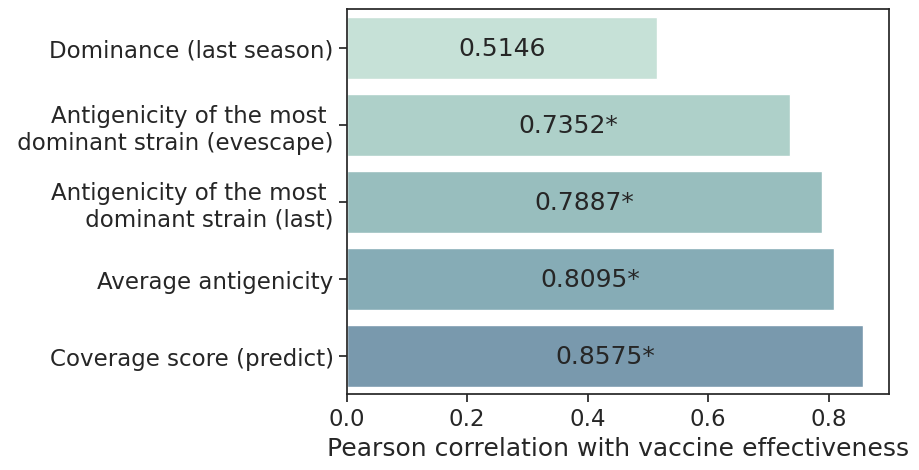

In [19]:

model_list_1 = [
                "Dominance (last)", 
                "HI of top-1 dominant strains (evescape)", 
                "HI of top-1 dominant strains (last)", 
                 "HI median", 
                "Escapability score (prediction)" , 
   
               ]

_models_results = models_results[models_results["model"].isin(model_list_1)]
_models_results = _models_results.set_index('model', drop=False)
_models_results = _models_results.reindex(model_list_1)

_models_results.loc['Dominance (last)','model'] = 'Dominance (last season)'
_models_results.loc['HI of top-1 dominant strains (evescape)','model'] = 'Antigenicity of the most \n dominant strain (evescape)'
_models_results.loc['HI of top-1 dominant strains (last)','model'] = 'Antigenicity of the most \n dominant strain (last)'
_models_results.loc['Escapability score (prediction)','model'] = 'Coverage score (predict)'
_models_results.loc["HI median",'model'] = 'Average antigenicity'


print(_models_results)

_models_results[""] = _models_results["model"]

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(7, 5)

ax = sns.barplot(_models_results, 
                 x="Pearson", y="", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5),
                 ax=ax
                )


for i in ax.containers:
#     print(i.datavalues)
    display_labels = []
    for value, p in zip(_models_results["Pearson"], _models_results["Pearson P"]):
        if p < 0.05:
            display_labels.append("%.4f*" % value)
        else:
            display_labels.append("%.4f" % value)
#     print(display_labels)
    ax.bar_label(i,labels=display_labels, label_type="center")
    
# ax.set_title("Subtype=%s" % ( "A/" + subtype.replace("_", "/").upper()))
ax.set_xlabel("Pearson correlation with vaccine effectiveness")

plt.savefig("figs/pearson_ve_all_models.pdf", format='pdf', bbox_inches='tight')

plt.show()

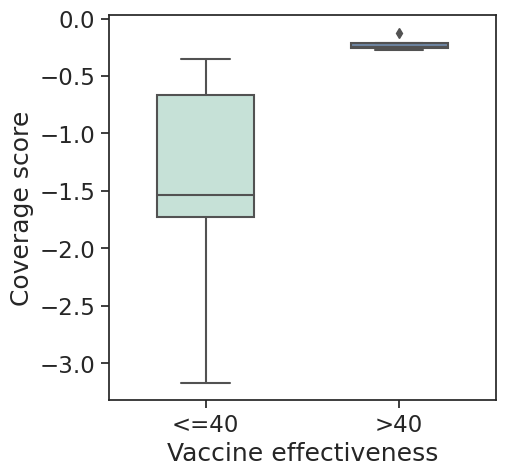

In [21]:
res["Vaccine effectiveness"] = [">40" if x > 40 else "<=40" for x in res["ve"]]
# print(res)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(5, 5)
ax = sns.boxplot(data=res[res['model'] == 'Escapability score (prediction)'], 
            x="Vaccine effectiveness", y="score", 
                 ax=ax,palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=2), width=0.5)
ax.set_ylabel("Coverage score")

plt.savefig("figs/ve_pred_boxplot.pdf", format='pdf', bbox_inches='tight')

plt.show()
